In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
sns.set(font='Arial')

In [15]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.seasonal import STL
plt.rc("figure", figsize=(16, 10))

In [2]:
df = pd.read_csv('..\\data\\pareto\\acasaluna_q.csv',index_col=0)
df=df.join(pd.read_csv('..\\data\\pareto\\acasalunr_q.csv',index_col=0))

df.index=df.index.rename('Date')
df.index=pd.DatetimeIndex(df.index,freq='QS-OCT')

In [3]:
nat_var = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='national',engine='openpyxl',index_col=0)
prov_var=pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='provincial',engine='openpyxl',index_col=0)
covid = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='covid_dummy',engine='openpyxl',index_col=0)
wti = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='wti',engine='openpyxl',index_col=0)


nat_var.index = nat_var.index.str.replace(' ','')
nat_var.index = nat_var.index.rename('Date')
nat_var.index = pd.PeriodIndex(nat_var.index,freq='Q').to_timestamp()

prov_var.index = prov_var.index.rename('Date')
prov_var.index = pd.PeriodIndex(prov_var.index,freq='Q').to_timestamp()


covid.index = covid.index.str.replace(' ','')
covid.index = covid.index.rename('Date')
covid.index = pd.PeriodIndex(covid.index,freq='Q').to_timestamp()

wti.index=wti.index.str.replace(' ','')
wti.index = wti.index.rename('Date')
wti.index = pd.PeriodIndex(wti.index,freq='Q').to_timestamp()

In [4]:
prov_var = prov_var.join(nat_var)
prov_var = prov_var.join(covid)
prov_var = prov_var.join(wti)

In [5]:
prov_var.columns

Index(['gdp_AB_2023', 'gdp_AB_2023_alt', 'unemp_AB_2023', 'unemp_AB_2023_alt',
       'emp_AB_2023', 'emp_AB_2023_alt', 'cpi_AB_2023', 'cpi_AB_2023_alt',
       'cpiyoy_AB_2023', 'cpiyoy_AB_2023_alt', 'policy_rate_base',
       'policy_rate_alt', 'Interest rate, 10-Year Benchmark Bond Yield',
       '5_year_mortgage_base', '5_year_mortgage_alt', 'COVID-19', 'Long COVID',
       'WTI_base', 'WTI_lower', 'WTI_upper'],
      dtype='object')

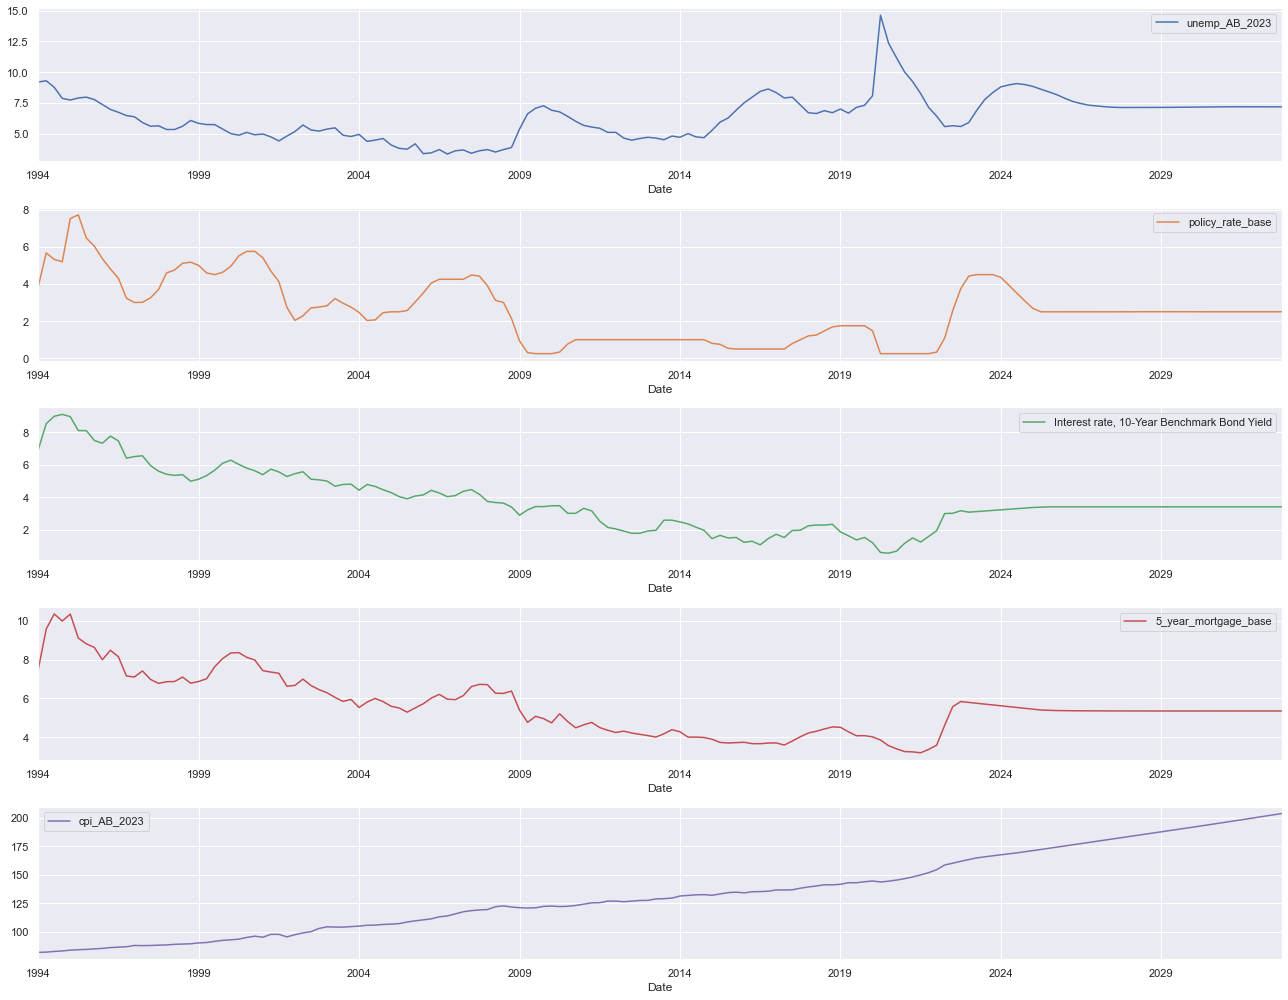

In [7]:
fig, ax = plt.subplots(nrows=5,ncols=1,figsize=(18,14))
prov_var['1994':][['unemp_AB_2023','policy_rate_base', 'Interest rate, 10-Year Benchmark Bond Yield','5_year_mortgage_base','cpi_AB_2023']].plot(ax=ax,subplots=True)
plt.tight_layout()

<AxesSubplot:xlabel='Date'>

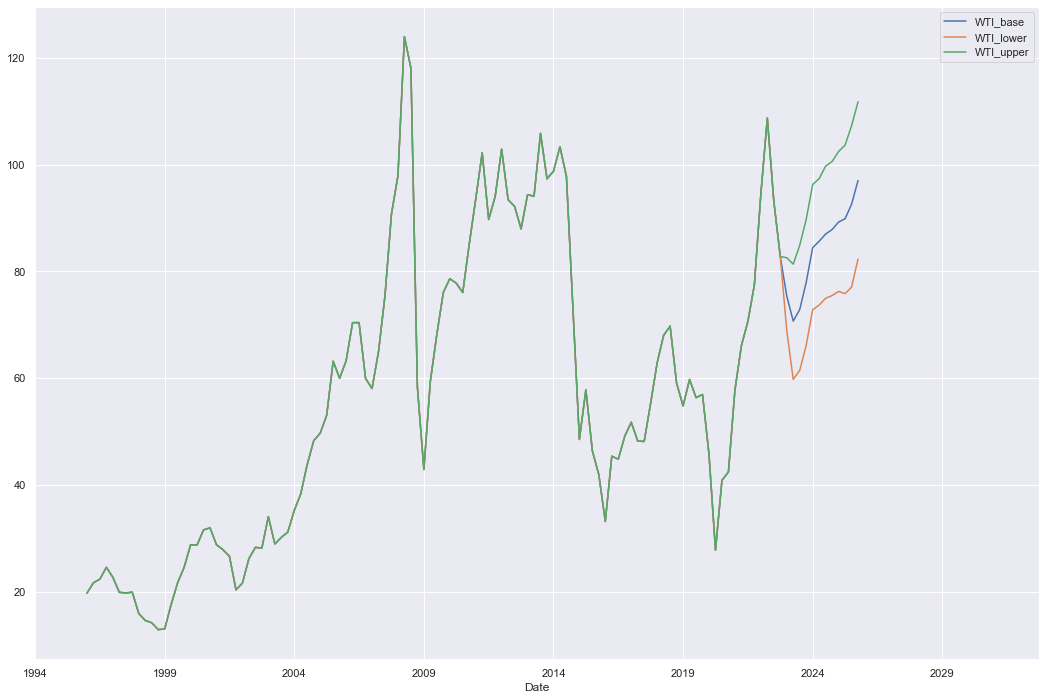

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))
prov_var['1994':][['WTI_base', 'WTI_lower', 'WTI_upper']].plot(ax=ax)


In [14]:
df.resample('A').sum()

,ACASALUNA_Q,ACASALUNR_Q
Date,,
1980-12-31,0.0,11599.0
1981-12-31,0.0,11775.0
1982-12-31,0.0,6852.0
1983-12-31,0.0,6965.0
1984-12-31,0.0,9181.0
1985-12-31,0.0,14274.0
1986-12-31,0.0,11294.0
1987-12-31,0.0,14337.0
1988-12-31,15928.0,15928.0


<AxesSubplot:xlabel='Date'>

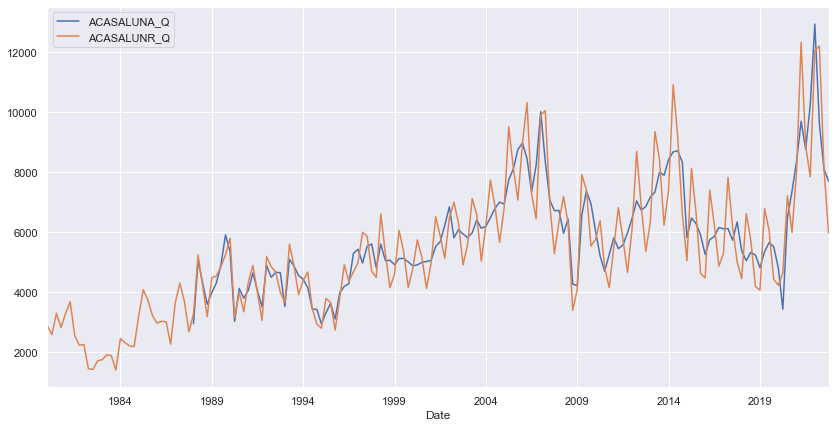

In [13]:
df.plot(figsize=(14,7))

In [17]:
df = prov_var.join(df)

In [18]:
sel_res = ardl_select_order(df['ACASALUNA_Q']['1996':'2022'],4,df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base']]['1996':'2022'],ic='aic',trend='n',maxorder=12)

In [20]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:            ACASALUNA_Q   No. Observations:                  108
Model:               ARDL(1, 9, 1, 2)   Log Likelihood                -824.960
Method:               Conditional MLE   S.D. of innovations            539.677
Date:                Fri, 24 Feb 2023   AIC                           1683.921
Time:                        00:59:39   BIC                           1729.359
Sample:                    04-01-1998   HQIC                          1702.341
                         - 10-01-2022                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ACASALUNA_Q.L1              0.9434      0.047     19.928      0.000       0.849       1.037
unemp_AB_2023.L0         -266.5130     80.399     -3.315      0.001    -426.216    -106.810
unemp_AB_2023.L1          438.1324    111.715      3.922      0.000     216.225     660.040
unemp_AB_2023.L2         -162.2825    108.805     -1.492      0.139    -378.410      53.845
unemp_AB_2023.L3          -53.7276    108.484     -0.495      0.622    -269.217     161.762
unemp_AB_2023.L4           57.6124    107.779      0.535      0.594    -156.478     271.703
unemp_AB_2023.L5         -151.2891    107.894     -1.402      0.164    -365.607      63.029
unemp_AB_2023.L6          188.7773    108.195      1.745      0.084     -26.138     403.693
unemp_AB_2023.L7          251.7246    108.491      2.320      0.023      36.221     467.228
unemp_AB_2023.L8         -587.5016    110.923     -5.296      0.000    -807.836    -367.167
unemp_AB_2023.L9          387.1607     86.276      4.487      0.000     215.783     558.538
WTI_upper.L0               26.9795      6.771      3.985      0.000      13.530      40.429
WTI_upper.L1              -27.4250      6.665     -4.115      0.000     -40.664     -14.186
5_year_mortgage_base.L0  -811.8029    264.070     -3.074      0.003   -1336.346    -287.259
5_year_mortgage_base.L1  -111.6222    394.579     -0.283      0.778    -895.405     672.160
5_year_mortgage_base.L2   886.8186    246.232      3.602      0.001     397.710    1375.928
===========================================================================================
"""

<AxesSubplot:xlabel='Date'>

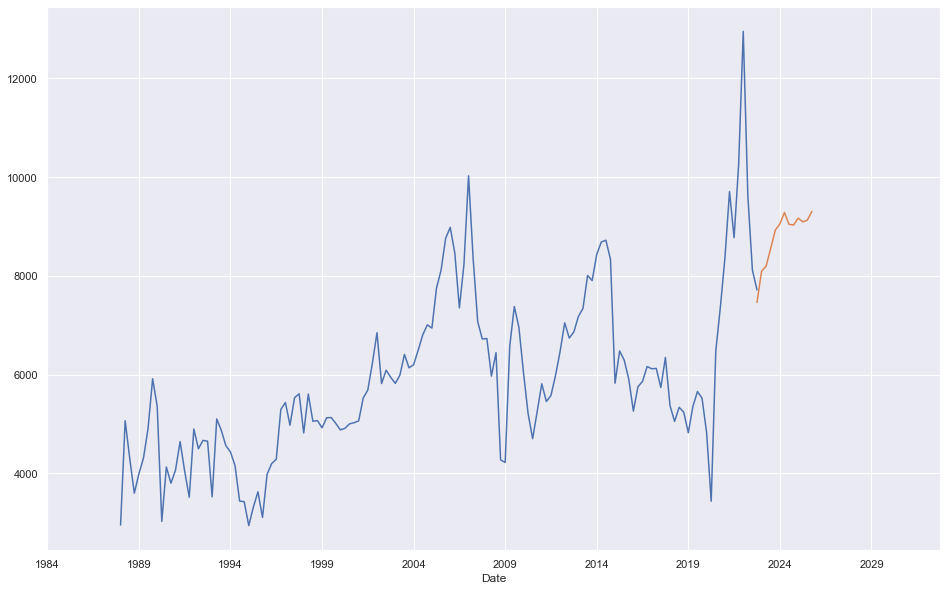

In [21]:
df['ACASALUNA_Q'].plot()
res.predict(start=107,end=119, exog_oos=df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base']]['2023':'2025'],dynamic=1).plot()

In [32]:
predict = res.get_prediction(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base']]['2023':'2025'])
predict_ci = predict.conf_int(alpha=0.6)

<AxesSubplot:xlabel='Date'>

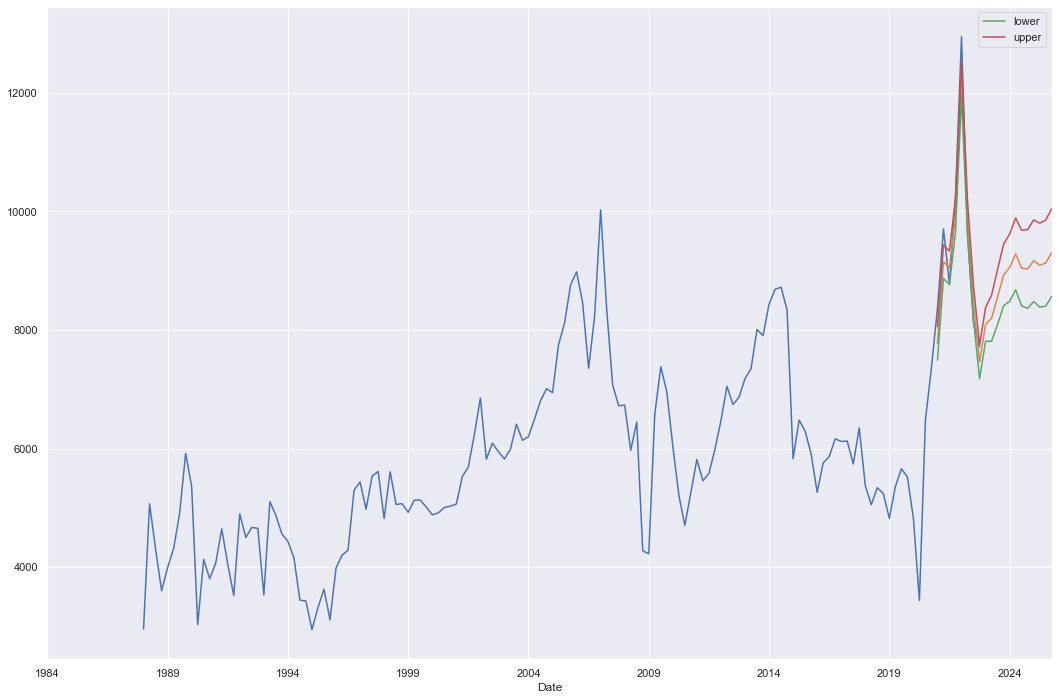

In [33]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

df['ACASALUNA_Q'][:'2022'].plot(ax=ax)

predict.predicted_mean.plot(ax=ax)
predict_ci.plot(ax=ax)

In [35]:
predict.predicted_mean.resample('A').sum()

2021-12-31    35903.827955
2022-12-31    38024.608572
2023-12-31    33773.397630
2024-12-31    36403.965904
2025-12-31    36692.715396
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [37]:
sel_res = ardl_select_order(df['ACASALUNA_Q']['1996':'2022'],4,df[['unemp_AB_2023','WTI_base','5_year_mortgage_base']]['1996':'2022'],ic='aic',trend='c',maxorder=12)
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:            ACASALUNA_Q   No. Observations:                  108
Model:               ARDL(1, 9, 1, 2)   Log Likelihood                -824.889
Method:               Conditional MLE   S.D. of innovations            539.316
Date:                Fri, 24 Feb 2023   AIC                           1685.778
Time:                        01:05:39   BIC                           1733.888
Sample:                    04-01-1998   HQIC                          1705.281
                         - 10-01-2022                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     355.8380   1074.303      0.331      0.741   -1778.452    2490.128
ACASALUNA_Q.L1              0.9317      0.059     15.731      0.000       0.814       1.049
unemp_AB_2023.L0         -277.5807     87.468     -3.174      0.002    -451.350    -103.811
unemp_AB_2023.L1          432.6676    113.524      3.811      0.000     207.132     658.203
unemp_AB_2023.L2         -160.4074    109.539     -1.464      0.147    -378.026      57.212
unemp_AB_2023.L3          -53.6662    109.070     -0.492      0.624    -270.353     163.021
unemp_AB_2023.L4           57.3609    108.365      0.529      0.598    -157.924     272.646
unemp_AB_2023.L5         -150.8448    108.485     -1.390      0.168    -366.370      64.681
unemp_AB_2023.L6          185.8872    109.129      1.703      0.092     -30.917     402.691
unemp_AB_2023.L7          252.3559    109.094      2.313      0.023      35.622     469.090
unemp_AB_2023.L8         -584.5982    111.866     -5.226      0.000    -806.840    -362.356
unemp_AB_2023.L9          382.5539     87.851      4.355      0.000     208.023     557.085
WTI_base.L0                26.8351      6.821      3.934      0.000      13.284      40.387
WTI_base.L1               -27.9394      6.879     -4.062      0.000     -41.605     -14.274
5_year_mortgage_base.L0  -799.6392    268.026     -2.983      0.004   -1332.119    -267.159
5_year_mortgage_base.L1  -122.6947    398.118     -0.308      0.759    -913.626     668.237
5_year_mortgage_base.L2   860.2998    260.187      3.306      0.001     343.392    1377.207
===========================================================================================
"""

In [38]:
res.predict(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_base','5_year_mortgage_base']]['2023':'2025'])

predict = res.get_prediction(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_base','5_year_mortgage_base']]['2023':'2025'])
predict_ci = predict.conf_int(alpha=0.7)

<AxesSubplot:xlabel='Date'>

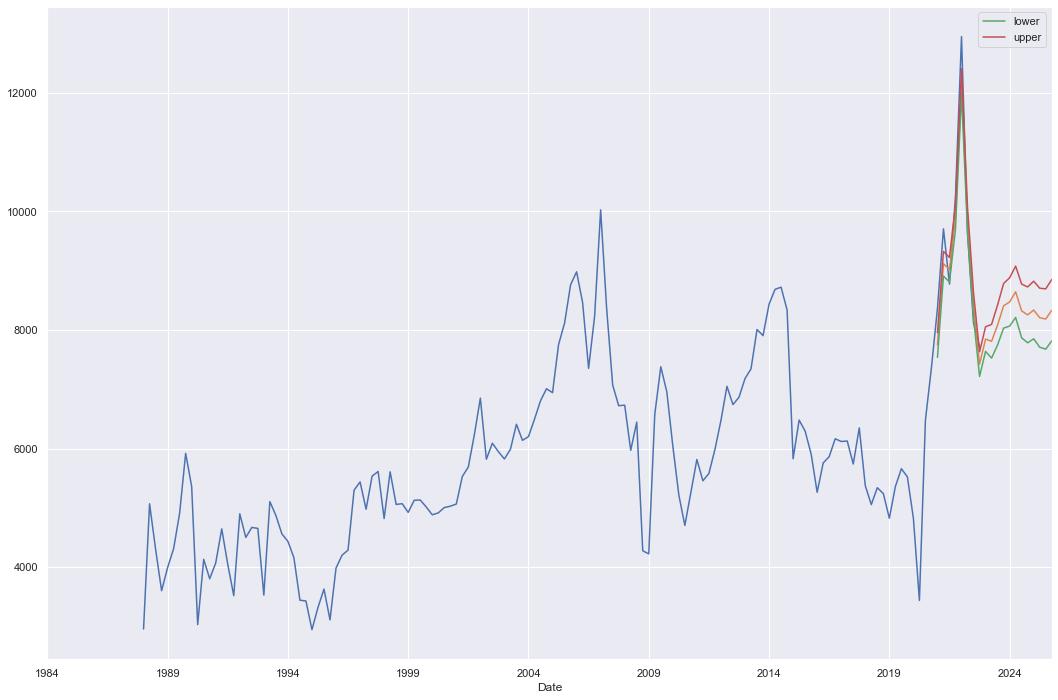

In [39]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

df['ACASALUNA_Q'][:'2022'].plot(ax=ax)

predict.predicted_mean.plot(ax=ax)
predict_ci.plot(ax=ax)

<AxesSubplot:xlabel='Date'>

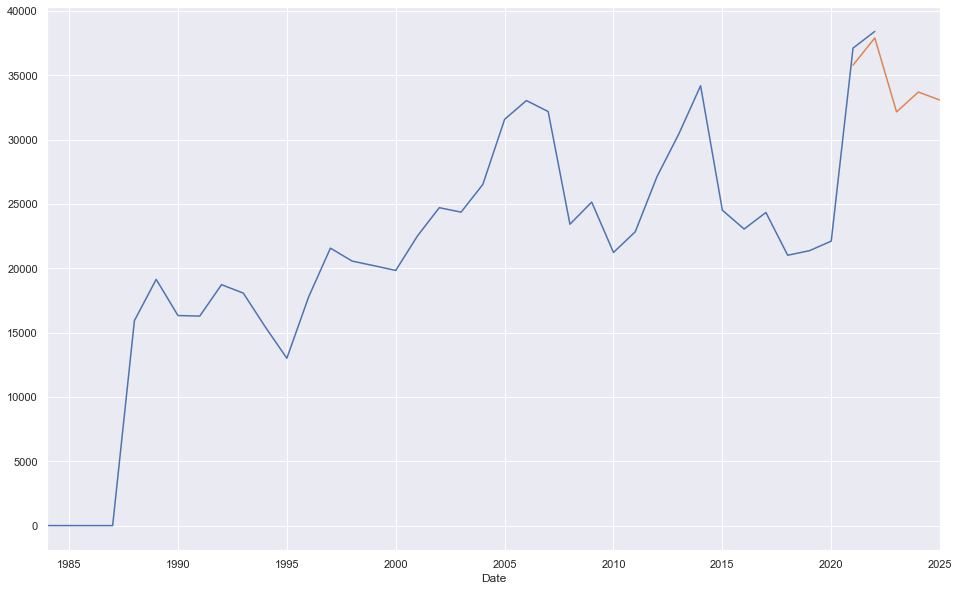

In [40]:
df['ACASALUNA_Q'][:'2022'].resample('A').sum().plot()
res.predict(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_base','5_year_mortgage_base']]['2023':'2025']).resample('A').sum().plot()

In [44]:
res.predict(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_base','5_year_mortgage_base']]['2023':'2025']).to_csv('sales_fcast_23.csv')

In [42]:
res.predict(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_base','5_year_mortgage_base']]['2023':'2025']).resample('A').sum()

2021-12-31    35783.885551
2022-12-31    37894.237581
2023-12-31    32146.256811
2024-12-31    33689.955502
2025-12-31    33058.800522
Freq: A-DEC, dtype: float64